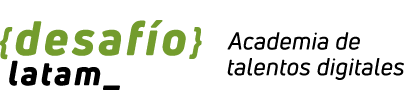

# <font color = 'green'>Solución Desafío - Redes Neuronales FeedForward Parte II</font>


## Carga de bibliotecas y datos

In [66]:
!pip install scikeras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import pickle

import keras
import scikeras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout  # Change here
from tensorflow.keras.optimizers import SGD, Adadelta, Adagrad
from keras.models import Sequential
from keras.initializers import HeNormal
from keras.constraints import max_norm
from keras.regularizers import l1, l2

In [67]:
df = pd.read_csv('hotel_bookings.csv')
#descartamos las variables irrelevantes
df = df.drop(columns=['index', 'arrival_date_year', 'agent', 'country',
                      'company', 'reservation_status', 'reservation_status_date'])
print(df.shape)
df.columns

(119390, 26)


Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests'],
      dtype='object')

Revisamos en búsqueda de valores ausentes

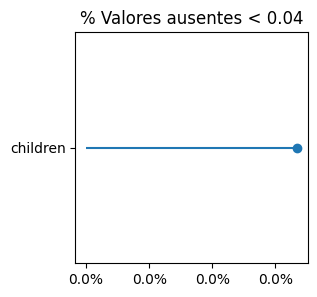

In [68]:
def viz_na(df, umbral=.04):
    n_obs = df.shape[0]

    na_ = df.apply(lambda x: np.sum(x.isnull())/n_obs, axis=0)
    na_ = na_[(na_ > 0) & (na_ < umbral)].sort_values(ascending=True)

    fig, ax = plt.subplots(figsize=(3, 3))

    # Make the plot
    ax.stem(na_.values, orientation='horizontal')
    ax.set_yticks(range(na_.shape[0]), na_.index)

    fmt = '%.1f%%' # Format you want the ticks, e.g. '40.00%'
    xticks = mtick.FormatStrFormatter(fmt)
    ax.xaxis.set_major_formatter(xticks)

    ax.set_title(f'% Valores ausentes < {umbral}')

    plt.show()

viz_na(df, umbral=.04)

In [69]:
# revisamos la variable children que presenta cuatro valores ausentes
df['children'].value_counts()

0.0     110796
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: children, dtype: int64

In [70]:
# Se eliminan los registros con valores ausentes
df = df.dropna(subset=['children'])
print(df.shape)

(119386, 26)


Cambiamos el tipo de dato de la variable children

In [71]:
df['children'] = df['children'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119386 entries, 0 to 119389
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119386 non-null  object 
 1   is_canceled                     119386 non-null  int64  
 2   lead_time                       119386 non-null  int64  
 3   arrival_date_month              119386 non-null  object 
 4   arrival_date_week_number        119386 non-null  int64  
 5   arrival_date_day_of_month       119386 non-null  int64  
 6   stays_in_weekend_nights         119386 non-null  int64  
 7   stays_in_week_nights            119386 non-null  int64  
 8   adults                          119386 non-null  int64  
 9   children                        119386 non-null  int64  
 10  babies                          119386 non-null  int64  
 11  meal                            119386 non-null  object 
 12  market_segment  

Analizamos la variable adr en busca valores atípicos

In [72]:
# adr: Tarifa media diaria definida dividiendo la suma de todas
# las transacciones de alojamiento por el número total de noches
# de estancia.
df['adr'].describe()

count    119386.000000
mean        101.833541
std          50.534664
min          -6.380000
25%          69.290000
50%          94.590000
75%         126.000000
max        5400.000000
Name: adr, dtype: float64

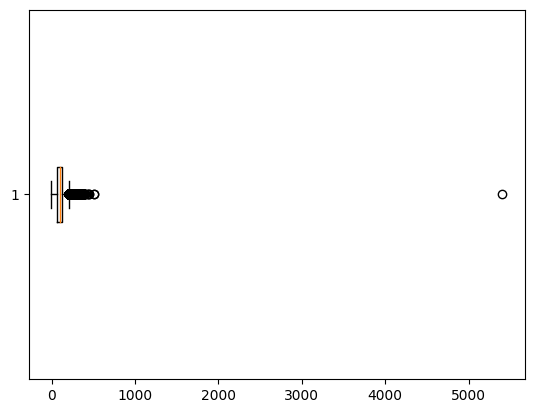

In [73]:
plt.boxplot(df['adr'], vert=False);

Se eliminan los tres valores outlier más extremos que se escapan por arriba y tres que se escapan por abajo (cuando corresponda) para la variable adr, cuando la cantidad total de outliers a eliminar (en este caso seis) sea menor al 4% del total de observaciones.

In [65]:
def drop_outliers(df_in, column, n_upper=1, n_lower=1):
    print(f'Cantidad de filas previo a la eliminación: {df_in.shape[0]}')

    q1 = np.percentile(df_in[column], 25)
    q3 = np.percentile(df_in[column], 75)
    iqr = q3 - q1

    upper_limit = q3 + 1.5 * iqr
    lower_limit = q1 - 1.5 * iqr

    # Selecciona los índices de las observaciones atípicas por encima
    idx_upper = df_in[df_in[column] > upper_limit].sort_values(by=column, ascending=False).head(n_upper).index
    # Selecciona los índices de las observaciones atípicas por debajo
    idx_lower = df_in[df_in[column] < lower_limit].sort_values(by=column, ascending=False).head(n_lower).index

    outliers = np.concatenate([idx_upper, idx_lower])
    df_outliers_removed = df_in.drop(outliers)

    print(f'Cantidad de filas luego de la eliminación: {df_outliers_removed.shape[0]}')

    return df_outliers_removed

# Llama a la función drop_outliers con el DataFrame original (df),
# la columna 'adr' y los parámetros n_upper=3, n_lower=3
df = drop_outliers(df_in=df, column='adr', n_upper=3, n_lower=3)


Cantidad de filas previo a la eliminación: 119383
Cantidad de filas luego de la eliminación: 119380


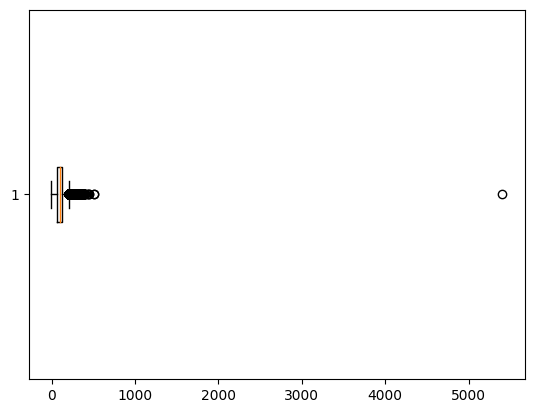

In [74]:
plt.boxplot(df['adr'], vert=False);

Se describen a continuación 5 variables relevantes respecto de la cancelación de la reserva.

(2, 3)


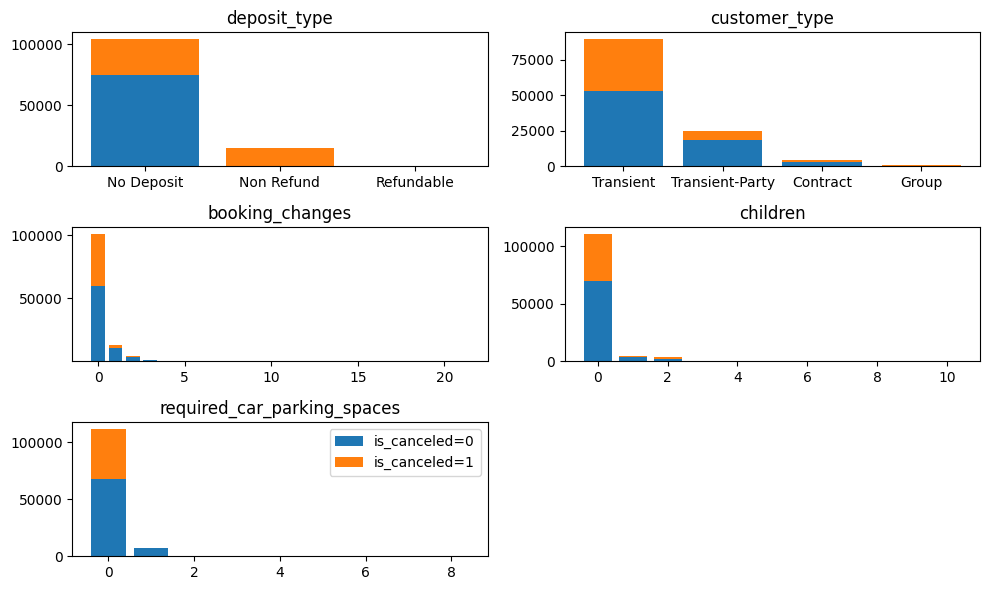

In [75]:
def viz_categorical_target(df, columns, target):
    max_col = 2

    if len(columns) < max_col:
        max_col = len(columns)

    nrows = len(columns)//max_col
    if len(columns) > max_col*nrows:
        nrows += 1

    print(f'({max_col}, {nrows})')
    fig = plt.figure(figsize=(max_col*5, nrows*2))
    val_cat = df[target].unique()

    for icol, col in enumerate(columns):
        df_tmp = pd.pivot_table(data=df, index=[col], columns=[target],
                        values='hotel', aggfunc='count', fill_value=0, margins=True, margins_name='tot')
        df_tmp = df_tmp.drop(index='tot', axis=0)
        df_tmp = df_tmp.sort_values(by='tot', ascending=False)

        group_count = np.array(df_tmp.index)
        values1 = np.array([])
        for i, cat in enumerate(val_cat):

            values_ = np.array(df_tmp.loc[:,cat])

            if i == 0:
                ax1 = fig.add_subplot(nrows, max_col, icol+1)
                values1 = values_

                ax1.set_title(col)
                ax1.bar(group_count, values_, label=target + f'={cat}')
            else:

                ax1.bar(group_count, values_, bottom=values1, label=target + f'={cat}')

    plt.legend()
    plt.tight_layout()
    plt.show()



features = ['deposit_type', 'customer_type', 'booking_changes', 'children', 'required_car_parking_spaces']
viz_categorical_target(df, features, 'is_canceled')

#### Se muestra la distribución de la variable adr para las clases reserva cancelada y no cancelada

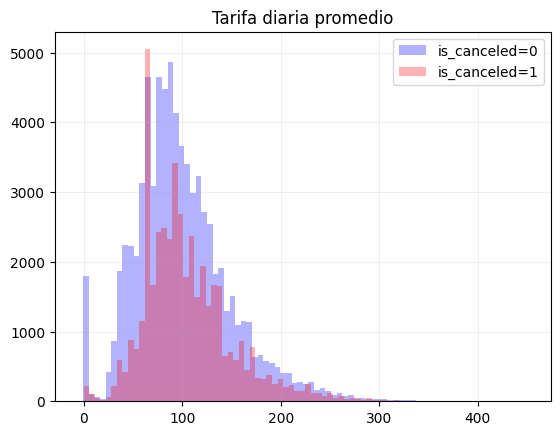

In [ ]:
plt.hist(x='adr', color='blue', alpha=.3, data=df[df['is_canceled']==0], label='is_canceled=0', bins=80)
plt.hist(x='adr', color='red', alpha=.3, data=df[df['is_canceled']==1], label='is_canceled=1', bins=80)
plt.title('Tarifa diaria promedio')
plt.grid(alpha=.2)
plt.legend();

Construiremos ahora las variables Dummies

In [76]:
df = pd.get_dummies(data=df, drop_first=True, dtype=int)
df.sample(10)

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
83430,0,20,5,29,1,2,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7716,1,77,35,22,1,2,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
50962,1,309,20,12,0,2,2,0,0,0,...,0,0,0,0,0,1,0,0,1,0
73661,1,234,35,29,0,4,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
114720,0,48,26,26,1,0,2,2,0,0,...,0,0,0,0,0,0,0,0,1,0
49225,1,99,15,8,0,2,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10134,1,92,7,15,0,3,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
20943,0,4,7,13,0,1,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
50409,1,53,18,30,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
53821,1,11,27,30,0,3,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Revisamos ahora el balance de las clases

In [77]:
df['is_canceled'].value_counts()

0    75166
1    44220
Name: is_canceled, dtype: int64

#### Se divide el conjunto en entrenamiento y test (33%) y se estándarizan las variables independientes

In [78]:
X = df.drop(columns=['is_canceled'], axis=1)
ss = StandardScaler()
X = ss.fit_transform(X)
y = df['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=23)

Construiremos ahora los dos modelos de red neuronal ,uno con funciones de activación sigmoidal y otro con relu.

In [79]:
def create_model(n_features, activations, n_hidden_layers, n_neurons,
                 k_initializer=HeNormal(), bias_initializer='zeros'):

    ann1 = Sequential()
    ann1.add(keras.Input(shape=(n_features, )))

    constraint = max_norm(3)

    for idx, hl in enumerate(range(1, n_hidden_layers+1)):
        ann1.add(
            Dense(
                units=n_neurons,
                use_bias=True,
                activation=activations[idx],
                kernel_initializer=k_initializer[idx],
                bias_initializer=bias_initializer[idx],
                kernel_constraint=constraint
            )
        )

    ann1.add(
        Dense(
            units=1,
            use_bias=True,
            activation='sigmoid',
            kernel_initializer='glorot_normal',
            bias_initializer='zeros',
            kernel_constraint=constraint
        )
    )

    return ann1

Construimos ahora el modelo usando distintas funciones de activación en capas ocultas.
- sigmoid
- relu
- sigmoid
- relu

In [80]:
ann1 = create_model(
    n_features=X_train.shape[1],
    activations=['tanh', 'relu', 'tanh'],
    n_hidden_layers=3,
    n_neurons=20,
    k_initializer=['glorot_normal', 'he_normal', 'glorot_normal'],
    bias_initializer=['glorot_uniform']*3
)

ann1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                1360      
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2221 (8.68 KB)
Trainable params: 2221 (8.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [81]:
EPOCHS=10

ann1.compile(
    optimizer=SGD(learning_rate=0.02),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history1 = ann1.fit(
    X_train, y_train, epochs=EPOCHS,
    batch_size=500,
    verbose=1,
    validation_split=.33
)

Epoch 1/10
108/108 [==============================] - 2s 5ms/step - loss: 0.6587 - accuracy: 0.6254 - val_loss: 0.6235 - val_accuracy: 0.6789
Epoch 2/10
108/108 [==============================] - 0s 3ms/step - loss: 0.5969 - accuracy: 0.7091 - val_loss: 0.5771 - val_accuracy: 0.7260
Epoch 3/10
108/108 [==============================] - 0s 4ms/step - loss: 0.5552 - accuracy: 0.7342 - val_loss: 0.5402 - val_accuracy: 0.7417
Epoch 4/10
108/108 [==============================] - 0s 3ms/step - loss: 0.5226 - accuracy: 0.7499 - val_loss: 0.5128 - val_accuracy: 0.7581
Epoch 5/10
108/108 [==============================] - 0s 3ms/step - loss: 0.4983 - accuracy: 0.7659 - val_loss: 0.4926 - val_accuracy: 0.7717
Epoch 6/10
108/108 [==============================] - 0s 3ms/step - loss: 0.4802 - accuracy: 0.7773 - val_loss: 0.4782 - val_accuracy: 0.7807
Epoch 7/10
108/108 [==============================] - 0s 3ms/step - loss: 0.4671 - accuracy: 0.7868 - val_loss: 0.4678 - val_accuracy: 0.7880
Epoch 

In [82]:
yhat = ann1.predict(X_test)
yhat_class = np.where(yhat > 0.5, 1, 0)

print(classification_report(y_test, yhat_class))

1232/1232 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.79      0.92      0.85     24886
           1       0.81      0.59      0.68     14512

    accuracy                           0.80     39398
   macro avg       0.80      0.76      0.77     39398
weighted avg       0.80      0.80      0.79     39398



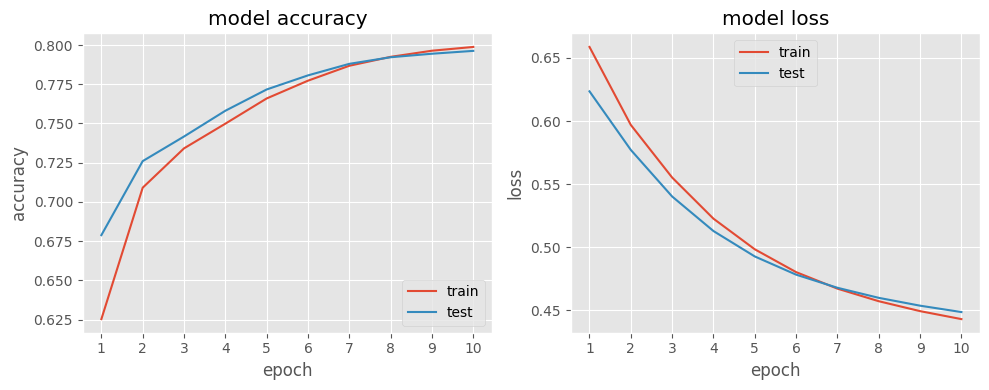

In [83]:
def viz_loss(history):
    plt.style.use('ggplot')
    epochs_ = len(history['accuracy'])
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # accuracy
    ax[0].plot(history['accuracy'])
    ax[0].plot(history['val_accuracy'])
    ax[0].set_xticks(np.arange(epochs_), np.arange(1, epochs_+1))
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'test'], loc='lower right')

    # loss
    ax[1].plot(history['loss'])
    ax[1].plot(history['val_loss'])
    ax[1].set_xticks(np.arange(epochs_), np.arange(1, epochs_+1))
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'test'], loc='upper center')

    plt.tight_layout()
    plt.show()

viz_loss(history1.history)

Construiremos ahora un modelo usando la función de activación **tanh** en todas las capas ocultas

In [84]:
ann2 = create_model(
    n_features=X_train.shape[1],
    activations=['tanh']*3,
    n_hidden_layers=3,
    n_neurons=20,
    k_initializer=['glorot_normal']*3,
    bias_initializer=['glorot_uniform']*3
)

ann2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 20)                1360      
                                                                 
 dense_5 (Dense)             (None, 20)                420       
                                                                 
 dense_6 (Dense)             (None, 20)                420       
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2221 (8.68 KB)
Trainable params: 2221 (8.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [85]:
EPOCHS=10

ann2.compile(
    optimizer=SGD(learning_rate=0.02),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history2 = ann2.fit(
    X_train, y_train, epochs=EPOCHS,
    batch_size=500,
    verbose=1,
    validation_split=.33
)

Epoch 1/10
108/108 [==============================] - 1s 4ms/step - loss: 0.6415 - accuracy: 0.6399 - val_loss: 0.6042 - val_accuracy: 0.7113
Epoch 2/10
108/108 [==============================] - 0s 3ms/step - loss: 0.5754 - accuracy: 0.7379 - val_loss: 0.5517 - val_accuracy: 0.7521
Epoch 3/10
108/108 [==============================] - 0s 4ms/step - loss: 0.5281 - accuracy: 0.7636 - val_loss: 0.5128 - val_accuracy: 0.7668
Epoch 4/10
108/108 [==============================] - 0s 3ms/step - loss: 0.4964 - accuracy: 0.7729 - val_loss: 0.4897 - val_accuracy: 0.7763
Epoch 5/10
108/108 [==============================] - 0s 3ms/step - loss: 0.4771 - accuracy: 0.7815 - val_loss: 0.4759 - val_accuracy: 0.7838
Epoch 6/10
108/108 [==============================] - 0s 3ms/step - loss: 0.4648 - accuracy: 0.7890 - val_loss: 0.4667 - val_accuracy: 0.7884
Epoch 7/10
108/108 [==============================] - 0s 3ms/step - loss: 0.4561 - accuracy: 0.7936 - val_loss: 0.4602 - val_accuracy: 0.7913
Epoch 

In [86]:
yhat = ann2.predict(X_test)
yhat_class = np.where(yhat > 0.5, 1, 0)

print(classification_report(y_test, yhat_class))

1232/1232 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.80      0.91      0.85     24886
           1       0.80      0.61      0.69     14512

    accuracy                           0.80     39398
   macro avg       0.80      0.76      0.77     39398
weighted avg       0.80      0.80      0.79     39398



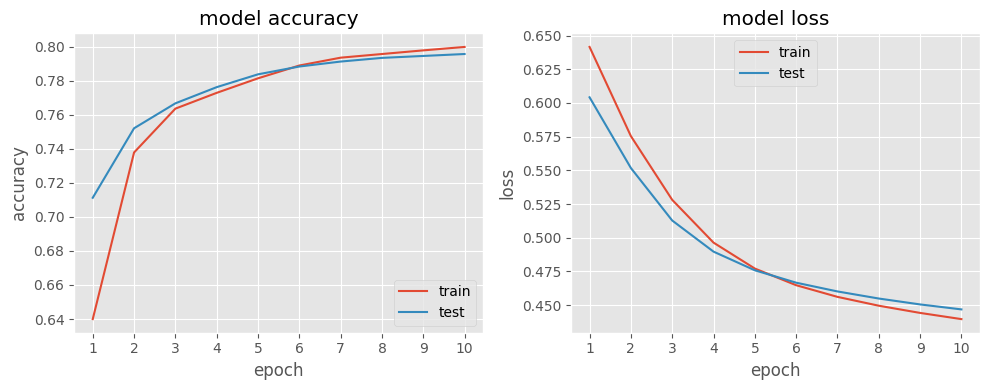

In [87]:
viz_loss(history2.history)

#### Construcción de red neuronal con búsqueda de grilla
Construiremos ahora una red neuronal con regularización Dropout, aplicando búsqueda de grilla para tres fold.

In [89]:

def create_model_grilla(n_hidden_layers=2, n_neurons=80,
                        activation='relu', dropout_rate=.001,
                        k_initializer='glorot_normal', meta={}):

    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]

    # Restricción para garantizar que la norma de cada
    # vector de pesos no exceda de tres.
    constraint = max_norm(3)

    # Arquitectura secuencial
    ann_tmp = Sequential()

    # Capa de entrada
    ann_tmp.add(keras.Input(shape=(n_features_in_, )))

    # Capas ocultas
    for hl in range(n_hidden_layers):
        ann_tmp.add(
            Dense(
                units=n_neurons,
                use_bias=True,
                activation=activation,
                kernel_initializer=k_initializer,
                bias_initializer='glorot_uniform',
                #kernel_regularizer=l2(l2=0.001),
                kernel_constraint=constraint
            )
        )
        ann_tmp.add(
            Dropout(rate=dropout_rate)
        )



    # Capa se salida
    ann_tmp.add(
        Dense(
            units=1,
            use_bias=True,
            activation='sigmoid',
            kernel_initializer='glorot_normal',
            bias_initializer='glorot_uniform',
            kernel_regularizer=l1(l1=0.001),
            kernel_constraint=constraint
        )
    )

    return ann_tmp

In [90]:
clf = KerasClassifier(
    create_model_grilla,
    loss='binary_crossentropy',
    verbose=1,
    metrics=['accuracy'],
    validation_split=.33,
)

In [91]:
# Espacio en el que se búsca los hiper parámetros óptimos
param_grid = {
    'model__n_hidden_layers': [3, 4],
    'model__n_neurons': [20],
    'model__activation': ['tanh'],
    'batch_size': [500],
    'epochs': [10],
    'optimizer': ['SGD', 'adagrad'],
    'optimizer__learning_rate': [0.03, 0.06],
    'model__dropout_rate': [0.001],
    'model__k_initializer': ['glorot_normal', 'glorot_uniform']
}

# GridSearchCV
grid = GridSearchCV(estimator=clf, param_grid=param_grid,
    scoring='accuracy', cv=3, verbose=0, n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

# Mostrar mejores hiper parámetros encontrados
print("\n\nBest: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/10
108/108 [==============================] - 2s 6ms/step - loss: 0.5067 - accuracy: 0.7550 - val_loss: 0.4482 - val_accuracy: 0.7966
Epoch 2/10
108/108 [==============================] - 0s 4ms/step - loss: 0.4319 - accuracy: 0.8046 - val_loss: 0.4327 - val_accuracy: 0.8027
Epoch 3/10
108/108 [==============================] - 0s 4ms/step - loss: 0.4195 - accuracy: 0.8098 - val_loss: 0.4244 - val_accuracy: 0.8052
Epoch 4/10
108/108 [==============================] - 0s 4ms/step - loss: 0.4115 - accuracy: 0.8134 - val_loss: 0.4207 - val_accuracy: 0.8037
Epoch 5/10
108/108 [==============================] - 0s 4ms/step - loss: 0.4059 - accuracy: 0.8140 - val_loss: 0.4233 - val_accuracy: 0.8039
Epoch 6/10
108/108 [==============================] - 0s 4ms/step - loss: 0.4014 - accuracy: 0.8151 - val_loss: 0.4230 - val_accuracy: 0.7977
Epoch 7/10
108/108 [==============================] - 0s 4ms/step - loss: 0.3981 - accuracy: 0.8165 - val_loss: 0.4106 - val_accuracy: 0.8099
Epoch 

In [92]:
yhat_class = grid_result.best_estimator_.predict(X_test)
print(classification_report(y_test, yhat_class))

79/79 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.83      0.89      0.86     24886
           1       0.79      0.68      0.73     14512

    accuracy                           0.81     39398
   macro avg       0.81      0.79      0.79     39398
weighted avg       0.81      0.81      0.81     39398



79/79 [==============================] - 0s 1ms/step


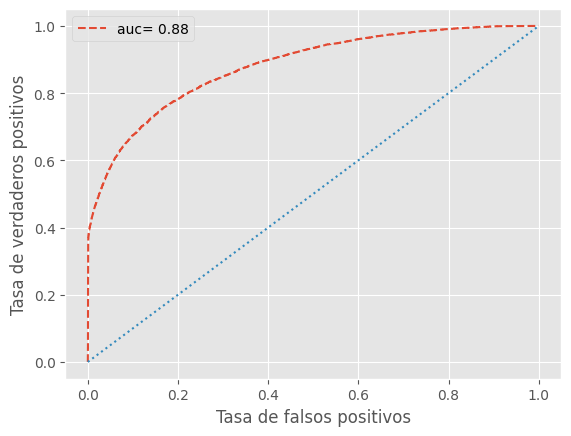

In [93]:
yhat_proba = grid_result.best_estimator_.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, yhat_proba)
auc = np.round(roc_auc_score(y_test, yhat_proba), 2)

plt.plot(fpr, tpr, '--', label=f'auc= {auc}')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.plot([0, 1], [0, 1], ':')
plt.legend();

Del conjunto original (sin los valores excluidos) escogemos ahora al azar cinco observaciones en que “deposit_type_Non Refund” sea cero, y con esto realizaremos una predicción usando el mejor modelo encontrado por la búsqueda de grilla anterior.

In [94]:
n_obs = 5

X_new = df[df['deposit_type_Non Refund']==0].sample(n_obs)
X_test_new = X_new.drop(columns='is_canceled')
y_test_new = X_new['is_canceled']

yhat_new = grid_result.best_estimator_.predict(X_test_new)
print(classification_report(y_test_new, yhat_new))

1/1 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.67      0.80         3

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5

